In [2]:
import os
import pandas as pd
from PIL import Image
import timm

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from torchvision import transforms
from torchvision.transforms import Resize, ToTensor, Normalize
from torchvision import models 
from tqdm import tqdm

In [20]:
# 테스트 데이터셋 폴더 경로를 지정해주세요.
test_dir = '/opt/ml/input/data/eval'

In [21]:
if torch.cuda.is_available():    
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla P40


In [22]:
class TestDataset(Dataset):
    def __init__(self, img_paths, transform):
        self.img_paths = img_paths
        self.transform = transform

    def __getitem__(self, index):
        image = Image.open(self.img_paths[index])

        if self.transform:
            image = self.transform(image)
        return image, self.img_paths[index]

    def __len__(self):
        return len(self.img_paths)

In [23]:
class MyModel(nn.Module):
    def __init__(self, num_classes: int = 1000):
        super(MyModel, self).__init__()
        self.backbone = models.resnext50_32x4d(pretrained=True)
        self.backbone.fc = nn.Linear(in_features=2048, out_features=18, bias=True)
        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.backbone(x)
        return x

In [27]:
model_path = "/opt/ml/model_save/04_08_v1/005_loss_5.3e-05_acc_0.98.ckpt"
model1 = MyModel()
model1.load_state_dict(torch.load(model_path))
model1.cuda()

model_path = "/opt/ml/code/backbone/train/2021_04_01/ResNext_2(current best)/v1/004_loss_0.00059.ckpt"
model2 = MyModel()
model2.load_state_dict(torch.load(model_path))
model2.cuda()

model_path = "/opt/ml/model_save/04_08_v3/006_loss_4.9e-05_acc_0.98.ckpt"
model3 = MyModel()
model3.load_state_dict(torch.load(model_path))
model3.cuda()


model_path = "/opt/ml/model_save/04_04_v3/004_loss_7.5e-05_acc_0.97.ckpt"
model4 = MyModel()
model4.load_state_dict(torch.load(model_path))
model4.cuda()

model_path = "/opt/ml/model_save/04_07_v3/4/006_loss_0.026_acc_0.89.ckpt"
model5 = MyModel()
model5.load_state_dict(torch.load(model_path))
model5.cuda()


MyModel(
  (backbone): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
        (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequ

In [28]:
# 이미지 transform지정
valid_transform = transforms.Compose([
    Resize((512, 384), Image.BILINEAR),
    transforms.CenterCrop((350,350)),
    ToTensor(),
    transforms.Normalize((0.56019358, 0.52410121, 0.501457), (0.23318603, 0.24300033, 0.24567522)),
])

In [29]:
# meta 데이터와 이미지 경로를 불러옵니다.
submission = pd.read_csv(os.path.join(test_dir, 'info.csv'))
image_dir = os.path.join(test_dir, 'images')

# Test Dataset 클래스 객체를 생성하고 DataLoader를 만듭니다.
image_paths = [os.path.join(image_dir, img_id) for img_id in submission.ImageID]
dataset = TestDataset(image_paths, valid_transform)

loader = DataLoader(
    dataset,
    shuffle=False
)

model1.eval()
model2.eval()
model3.eval()
model4.eval()
model5.eval()

pred_result = []

# 모델이 테스트 데이터셋을 예측하고 결과를 저장합니다.
all_predictions = []
for images, path in tqdm(loader):
    temp = []
    temp.append(path)
    with torch.no_grad():
        images = images.type(torch.FloatTensor).to(device)
        pred1 = model1(images)
        pred2 = model2(images)
#         pred3 = model3(images)
        pred4 = model4(images)
#         pred5 = model5(images)
        
        pred = (pred1 + pred2 + pred4) / 3
        pred = pred.argmax(dim=-1)
        temp.append(pred)
        all_predictions.extend(pred.cpu().numpy())
    pred_result.append(temp)
submission['ans'] = all_predictions

# 제출할 파일을 저장합니다.
submission.to_csv(os.path.join(test_dir, 'submission.csv'), index=False)
print('test inference is done!')

100%|██████████| 12600/12600 [21:16<00:00,  9.87it/s]


test inference is done!


In [45]:
import matplotlib.pyplot as plt
pred_result_iter = iter(pred_result)

In [48]:
print(next(pred_result_iter))

[('/opt/ml/input/data/eval/images/cbc5c6e168e63498590db46022617123f1fe1268.jpg',), tensor([13], device='cuda:0')]


In [82]:
def show_images(pred_result_iter, n=5, rows = 1, cols = 5, title = 'Default'):
    plt.figure(figsize=(16,10))
    plt.suptitle(title, fontsize = 16)
#     sampleList = random.sample(paths, n)
    
    for k in range(n):
        img, label = next(pred_result_iter)
        
        label = label.cpu().numpy()[0]
        img = Image.open(img[0])
        
#         img = valid_transform(img)
#         img = img.reshape(350,350,3)
#         print(type(img))
        # image = resize(image, (200, 200), anti_aliasing=True)

        plt.subplot(rows, cols, k+1)
        plt.imshow(img)
        plt.axis('off')
        
        plt.title("label:%s"%(label))

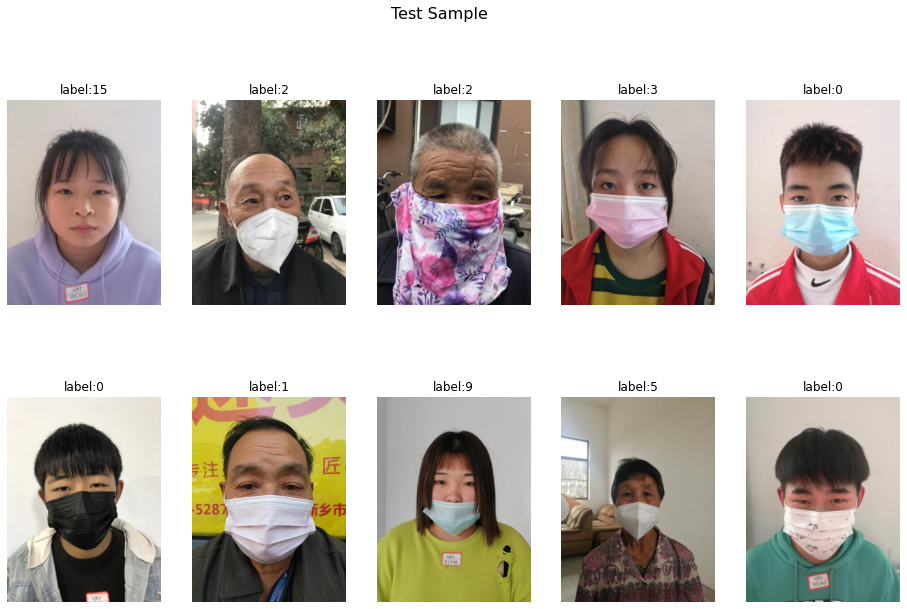

In [83]:
show_images(pred_result_iter, n=10, rows=2, cols= 5, title='Test Sample')